In [2]:
from keras.datasets import mnist
from keras.layers import Input, Conv2D, MaxPool2D, Reshape, Dense, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
(xTrain0, yTrain0), (xTest0, yTest0) = mnist.load_data()
xTrain0 = xTrain0[:10000]
xTrain0, xTest0 = xTrain0/255., xTest0/255.
print(xTrain0.shape, yTrain0.shape, xTest0.shape, yTest0.shape)

(10000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
xTrain, xTest = np.zeros((10000,32,32)), np.zeros((10000,32,32))
for i in range(10000):
    xTrain[i] = cv2.resize(xTrain0[i], (32,32), interpolation=cv2.INTER_CUBIC)
    xTest[i] = cv2.resize(xTest0[i], (32,32), interpolation=cv2.INTER_CUBIC)
xTrain = xTrain.reshape(10000,32,32,1)
xTest = xTest.reshape(10000,32,32,1)

In [5]:
input_layer = Input(shape=(32,32,1))
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
x = MaxPool2D(pool_size=(2,2), padding='same')(x)
x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), padding='same')(x)

x = Reshape(target_shape=(1024,))(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
bn = Dense(10, name='bottle_neck', activation='relu')(x)
x = Dense(64, activation='relu')(bn)
x = Dense(256, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Reshape(target_shape=(8,8,16))(x)

x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
output_layer = Conv2D(filters=1, kernel_size=(3,3), padding='same')(x)

encoder = Model(input_layer, bn)
autoencoder = Model(input_layer, output_layer) #output_layer
encoder.summary()
autoencoder.summary()
autoencoder.compile(optimizer=Adam(lr=0.0001), loss='mse')


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262

In [6]:
history = autoencoder.fit(xTrain, xTrain, epochs=100, batch_size=128, \
    validation_data=(xTest, xTest))


Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 15s 1ms/step - loss: 0.0901 - val_loss: 0.0667
Epoch 2/100
10000/10000 [==============================] - 15s 1ms/step - loss: 0.0649 - val_loss: 0.0629
Epoch 3/100
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0585 - val_loss: 0.0548
Epoch 4/100
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0518 - val_loss: 0.0486
Epoch 5/100
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0461 - val_loss: 0.0440
Epoch 6/100
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0417 - val_loss: 0.0400
Epoch 7/100
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0382 - val_loss: 0.0373
Epoch 8/100
10000/10000 [==============================] - 17s 2ms/step - loss: 0.0360 - val_loss: 0.0356
Epoch 9/100
10000/10000 [==============================] - 18s 2ms/step - loss: 0.0344 - val_loss: 0.

10000/10000 [==============================] - 20s 2ms/step - loss: 0.0177 - val_loss: 0.0191
Epoch 76/100
10000/10000 [==============================] - 20s 2ms/step - loss: 0.0176 - val_loss: 0.0191
Epoch 77/100
10000/10000 [==============================] - 20s 2ms/step - loss: 0.0176 - val_loss: 0.0191
Epoch 78/100
10000/10000 [==============================] - 20s 2ms/step - loss: 0.0175 - val_loss: 0.0192
Epoch 79/100
10000/10000 [==============================] - 20s 2ms/step - loss: 0.0175 - val_loss: 0.0190
Epoch 80/100
10000/10000 [==============================] - 20s 2ms/step - loss: 0.0175 - val_loss: 0.0190
Epoch 81/100
10000/10000 [==============================] - 19s 2ms/step - loss: 0.0174 - val_loss: 0.0190
Epoch 82/100
10000/10000 [==============================] - 19s 2ms/step - loss: 0.0174 - val_loss: 0.0189
Epoch 83/100
10000/10000 [==============================] - 20s 2ms/step - loss: 0.0173 - val_loss: 0.0190
Epoch 84/100
10000/10000 [========================

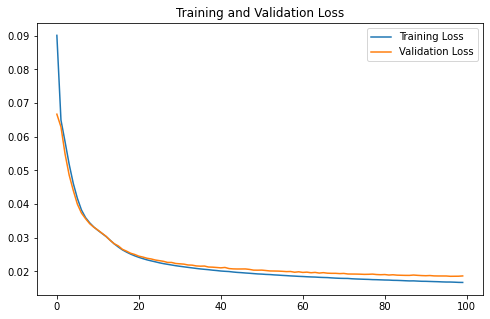

In [7]:
loss, val_loss = history.history['loss'], history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
autoencoder.save("CAE.h5")

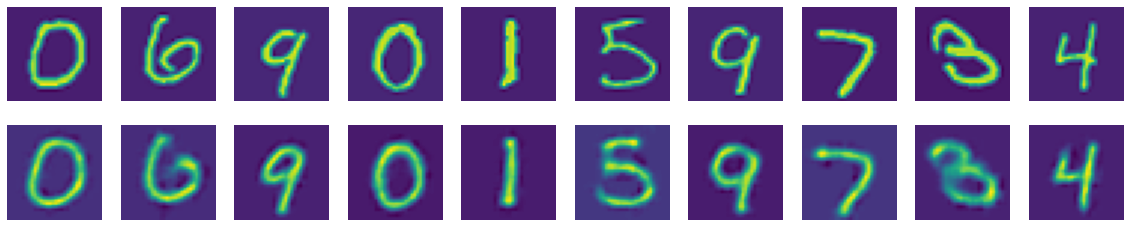

In [22]:
start = 10
pred = autoencoder.predict( xTest[start:start+10] )
pred = pred.reshape(10, 32, 32)

plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(xTest[start+i].reshape(32,32))
    plt.axis('off')
    
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(pred[i])
    plt.axis('off')
    
plt.show()

In [23]:
feature = encoder.predict( xTrain )
print(xTrain.shape, feature.shape)

(10000, 32, 32, 1) (10000, 10)


In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduction = pca.fit_transform(feature)
print(reduction.shape)

(10000, 2)


In [25]:
x = [ [] for i in range(10)]
y = [ [] for i in range(10)]
for i in range(len(xTest)):
    x[ yTrain0[i] ].append( reduction[i][0] )
    y[ yTrain0[i] ].append( reduction[i][1] )

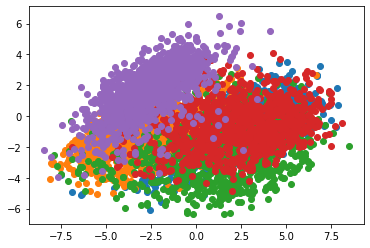

In [26]:
plt.scatter(x[0], y[0])
plt.scatter(x[1], y[1])
plt.scatter(x[2], y[2])
plt.scatter(x[3], y[3])
plt.scatter(x[4], y[4])
#plt.scatter(x[5], y[5])
plt.show()

In [117]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10).fit(feature)
P = kmeans.predict(feature)
print(P.shape)

(10000,)


In [118]:
L = np.zeros((10,10))
for i in range(10000):
    L[ P[i] ][ yTest0[i] ]+=1
print(L)

for i in range(10):
    print(i, np.argmax(L[i]))

[[108. 103. 114.  78.  89.  74.  77. 106.  91.  97.]
 [ 63.  75.  72.  63.  72.  61.  66.  65.  74.  80.]
 [108. 128. 118. 122. 117. 115. 108. 124. 112. 129.]
 [ 62.  62.  54.  50.  68.  46.  59.  61.  59.  63.]
 [145. 162. 135. 150. 145. 128. 140. 152. 128. 129.]
 [ 90.  88.  96.  93.  73.  61.  91.  81.  74.  78.]
 [156. 160. 149. 146. 141. 120. 140. 142. 128. 112.]
 [ 88. 128. 105.  97.  84.  93. 111.  98. 117. 113.]
 [ 87.  94.  86.  84.  84.  81.  74. 102.  83. 110.]
 [ 73. 135. 103. 127. 109. 113.  92.  97. 108.  98.]]
0 2
1 9
2 9
3 4
4 1
5 2
6 1
7 1
8 9
9 1
